# Evaluation
This notebook evaluates the trained BertImage model on the test set. The notebook generates classification metrics, confusion matrix, ROC curve, and Precision-Recall curve.
It covers:
1.  **Configuration**: Initialises the variables to be used throughout the notebook.
2.  **Load Model**: Load the pretrained model to be used for evaluation.
3.  **Run Evaluation on Test Set**: Use the loaded model to run the evaluation on the test set. Save the results into a csv folder.
4.  **Classification & Macro F1**: Print a classification and Macro F1-Score in order to know how well the model performed on the test set.
5. **Plots**: Plot a ``Confusion Matrix``, an ``ROC Curve`` and a ``Precision-Recall Curve``.

In [11]:
import importlib
import subprocess
import sys

def check_and_install_libraries(libraries):
    print("Checking and installing required libraries...")
    for library, package_name in libraries.items():
        try:
            importlib.import_module(library)
            print(f"   [OK] '{library}' is already installed.")
        except ImportError:
            print(f"   [MISSING] '{library}' not found. Installing '{package_name}'...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
                print(f"   [INSTALLED] '{package_name}' installed successfully.")
            except subprocess.CalledProcessError:
                print(f"   [ERROR] Failed to install '{package_name}'. Please install it manually.")

required_libraries = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "sklearn": "scikit-learn",
    "torch": "torch",
    "tqdm": "tqdm"
}

check_and_install_libraries(required_libraries)

import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
from sklearn.calibration import calibration_curve

Checking and installing required libraries...
   [OK] 'numpy' is already installed.
   [OK] 'pandas' is already installed.
   [OK] 'matplotlib' is already installed.
   [OK] 'seaborn' is already installed.
   [OK] 'sklearn' is already installed.
   [OK] 'torch' is already installed.
   [OK] 'tqdm' is already installed.


## 1. Configuration

In [12]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
BASE_DIR = os.path.join(PROJECT_ROOT, '5. Dementia Model')
sys.path.append(BASE_DIR)

MODEL_PATH = os.path.join(BASE_DIR, "saved_models", "best_model.pth")
SAVE_DIR = os.path.join(PROJECT_ROOT, "Other", "b. Diagram of Evaluation")
MISCLASSIFIED_DIR = os.path.join(SAVE_DIR, "misclassified_images")
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(MISCLASSIFIED_DIR, exist_ok=True)

# Model / data settings
ROBERTA_MODEL_NAME = "FacebookAI/roberta-base"
BATCH_SIZE = 32
PROBABILITY_THRESHOLD = 0.5

# Output filenames
CONF_MATRIX_FILE = "confusion_matrix.png"
ROC_CURVE_FILE   = "roc_curve.png"
PR_CURVE_FILE    = "precision_recall_curve.png"
CLASS_REPORT_FILE = "classification_report.png"
HISTO_PLOT = "predicted_probability_histogram.png"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Model path:   {MODEL_PATH}")
print(f"Save dir:     {SAVE_DIR}")

Using device: cuda
Model path:   d:\Uni\thesis final\5. Dementia Model\saved_models\best_model.pth
Save dir:     d:\Uni\thesis final\Other\b. Diagram of Evaluation


## 2. Load Model

In [13]:
from cached_adresso_dataset import adresso_loader
from bert_image import BertImage

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

print(f"Loading model from {MODEL_PATH}...")

# Initialise model structure - nfinetune=0 freezes backbone — weights will be overwritten
model = BertImage(nfinetune=0)

# Load saved weights
state_dict = torch.load(MODEL_PATH, map_location=device)

# Strip DataParallel 'module.' prefix if present
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.to(device)
model.eval()
print("Model loaded successfully.")

Loading model from d:\Uni\thesis final\5. Dementia Model\saved_models\best_model.pth...


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


## 3. Run Evaluation on Test Set

Pass the test set to the model in order to see how well the model performs on unseen dataset.

In [14]:
print("Starting evaluation on test set...")
loader = adresso_loader(phase="test", batch_size=BATCH_SIZE, base_path=BASE_DIR)

y_true   = []
y_probs  = []
records  = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Evaluating"):
        pixels         = batch["pixels"].to(device)
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].cpu().numpy()

        transcripts = batch.get("raw_texts",   [""]       * len(labels))
        file_names  = batch.get("file_names",  ["unknown"] * len(labels))

        outputs = model(pixels, input_ids, attention_mask)
        probs   = outputs.squeeze().cpu().numpy()

        for i in range(len(probs)):
            prob       = float(probs[i])
            true_label = int(labels[i])
            pred_label = int(prob >= PROBABILITY_THRESHOLD)

            y_probs.append(prob)
            y_true.append(true_label)

            records.append({
                "file_name":       file_names[i],
                "transcript":      transcripts[i],
                "true_label":      true_label,
                "predicted_label": pred_label,
                "probability":     round(prob, 4),
                "correct":         pred_label == true_label
            })

            if pred_label != true_label:
                img = pixels[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                img = (img * 255).astype(np.uint8)

                safe_name = os.path.splitext(os.path.basename(file_names[i]))[0]
                plt.imsave(os.path.join(MISCLASSIFIED_DIR, f"misclassified_{safe_name}.png"), img)


# Save per-sample details
df = pd.DataFrame(records)
csv_path = os.path.join(SAVE_DIR, "evaluation_details.csv")
df.to_csv(csv_path, index=False)
print(f"Saved evaluation_details.csv → {csv_path}")

y_true  = np.array(y_true)
y_probs = np.array(y_probs)
y_pred  = (y_probs >= PROBABILITY_THRESHOLD).astype(int)

Starting evaluation on test set...
Loading cached dataset: precomputed_test.pt


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

Saved evaluation_details.csv → d:\Uni\thesis final\Other\b. Diagram of Evaluation\evaluation_details.csv


## 4. Classification Report & Macro F1

In [15]:
print("\n" + "="*80)
print("       Evaluation Report")
print("="*80)
print(classification_report(y_true, y_pred, target_names=["Control", "Dementia"]))

print("\n" + "="*80)
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1 Score: {macro_f1:.4f}")
print("\n" + "="*80)


       Evaluation Report
              precision    recall  f1-score   support

     Control       0.72      0.73      0.73        56
    Dementia       0.73      0.72      0.73        57

    accuracy                           0.73       113
   macro avg       0.73      0.73      0.73       113
weighted avg       0.73      0.73      0.73       113


Macro F1 Score: 0.7257



## 5. Plots

### 5a. Confusion Matrix

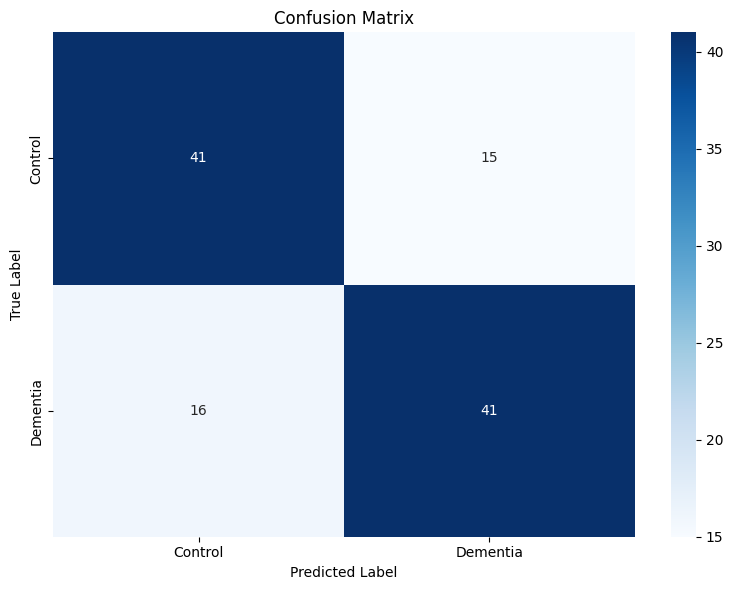

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Control", "Dementia"],
            yticklabels=["Control", "Dementia"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, CONF_MATRIX_FILE), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### 5b. ROC Curve

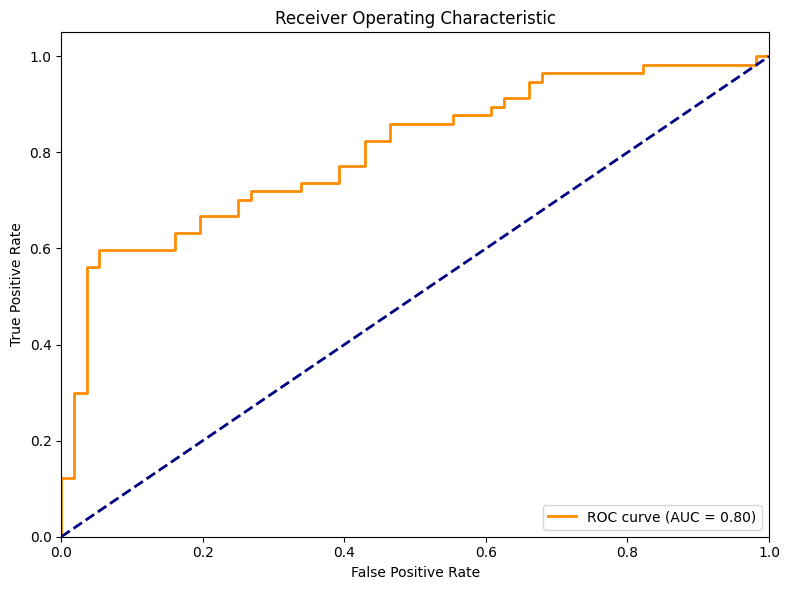

In [17]:
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, ROC_CURVE_FILE), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### 5c. Precision-Recall Curve

The **Precision-Recall Curve** is plotted. It is then used to find the Area Under the Curver in order to get a result for the **PR-AUC**. This was based on [1].

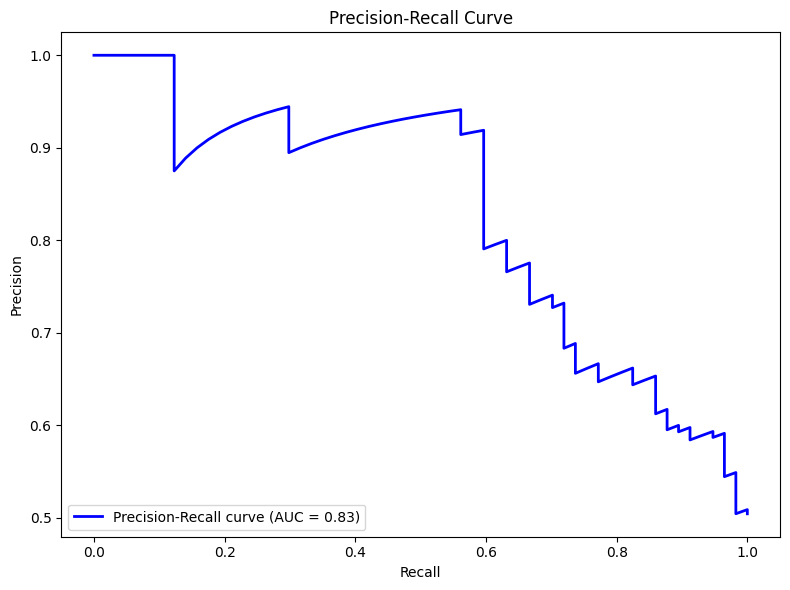

In [18]:
val_precision, val_recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(val_recall, val_precision)

plt.figure(figsize=(8, 6))
plt.plot(val_recall, val_precision, color="blue", lw=2,
         label=f"Precision-Recall curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, PR_CURVE_FILE), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

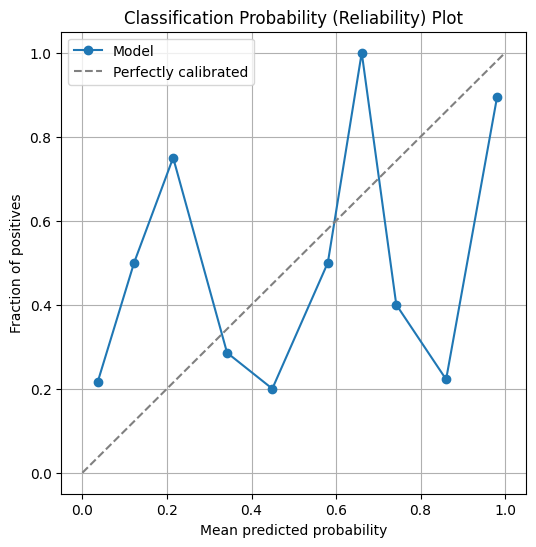

In [19]:
frac_pos, mean_pred = calibration_curve(
    y_true,
    y_probs,
    n_bins=10,
    strategy="uniform"
)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred, frac_pos, "o-", label="Model")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Classification Probability (Reliability) Plot")
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(SAVE_DIR, CLASS_REPORT_FILE), dpi=300, bbox_inches="tight")

plt.show()

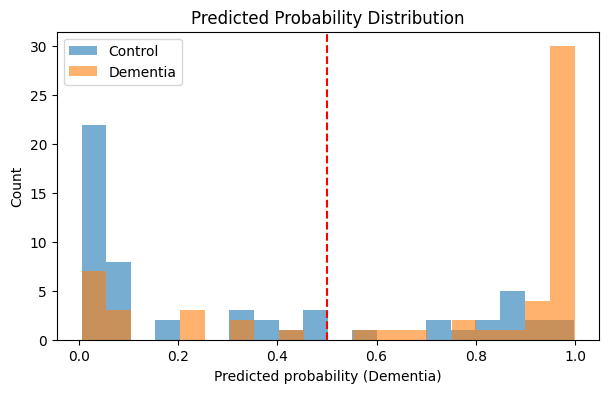

In [20]:
plt.figure(figsize=(7,4))
plt.hist(y_probs[y_true == 0], bins=20, alpha=0.6, label="Control")
plt.hist(y_probs[y_true == 1], bins=20, alpha=0.6, label="Dementia")
plt.axvline(PROBABILITY_THRESHOLD, color="red", linestyle="--")
plt.xlabel("Predicted probability (Dementia)")
plt.ylabel("Count")
plt.title("Predicted Probability Distribution")
plt.legend()

plt.savefig(os.path.join(SAVE_DIR, HISTO_PLOT), dpi=300, bbox_inches="tight")

plt.show()

[1] “sklearn.metrics.average_precision_score — scikit-learn 0.24.1 documentation,” scikit-learn.org. Available: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html